In [ ]:
# Importar as bibliotecas
import numpy as np
from skimage import data
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize

In [ ]:
# Função que retorna os vizinhos de um pixel em uma imagem.
# Input: Uma imagem, um inteiro com a linha e outro com a coluna do pixel que se deseja obter a vizinhança.
# Output: Uma lista com os vizinhos de um pixel, sendo 0 o pixel do centro e em sequência os vizinhos em sentido horário começando no pixel acima do centro.
def get_neighbors(img, row, col):
    img_pad = np.pad(img, 1) # Adiciona 0s ao redor da imagem.
    
    # Ajusta a posição da linha e coluna depois de inserir os 0s.
    row += 1 
    col += 1
    
    neighbors = np.empty(9, dtype=np.uint8)
    neighbors[0] = img_pad[row, col]           # P1
    neighbors[1] = img_pad[row - 1, col]       # P2
    neighbors[2] = img_pad[row - 1, col + 1]   # P3
    neighbors[3] = img_pad[row, col + 1]       # P4
    neighbors[4] = img_pad[row + 1, col + 1]   # P5
    neighbors[5] = img_pad[row + 1, col]       # P6
    neighbors[6] = img_pad[row + 1, col - 1]   # P7
    neighbors[7] = img_pad[row, col - 1]       # P8
    neighbors[8] = img_pad[row - 1, col -1]    # P9
    
    return neighbors

In [ ]:
# Função que retorna a soma dos vizinhos de um pixel.
# Input: Uma lista onde o 0 é o píxel do centro e os demais seus vizinhos.
# Output: A soma dos vizinhos.
def N(neighbors):
    # Para não alterar a soma, garanta que o centro P1 é 0.
    neighbors[0] = 0
    return np.sum(neighbors)

In [ ]:
# Função que retorna o número de transições 0 - 1 entre os vizinhos de um pixel na ordem P2..P9 e P9,P2.
# Input: Uma lista onde o 0 é o píxel do centro e os demais seus vizinhos.
# Output: O número de transições 0 - 1 na lista de vizinhos.
def T(neighbors):
    transicoes = 0
   
    # Verifica do P2 ao P9.
    for i in range(1, len(neighbors) - 1): 
        p_atual = neighbors[i]
        p_prox = neighbors[i + 1]
        if p_atual == 0 and p_prox == 1:
            transicoes += 1

    # Verifica entre P9 ao P2.
    if neighbors[8] == 0 and neighbors[1] == 1:
        transicoes += 1
        
    return transicoes

In [ ]:
# Função que verifica se o passo um do processo de gerar o esqueleto de um objeto é atendido.
# Input: Uma imagem, um inteiro com a linha e outro com a coluna do pixel que se deseja obter a vizinhança.
# Output: Verdadeiro se todos os critérios foram atendidos, falso caso contrário.
def passo1(img, row, col):
    # Obtém os vizinhos do pixel.
    neighbors = get_neighbors(img, row, col)
    
    # Critério A: Quantidade de vizinhos não nulos.
    if N(neighbors) < 2 or N(neighbors) > 6:
        return False
    
    # Critério B: Quantidade de transições 0-1.
    if T(neighbors) != 1:
        return False
    
    # Critério C: P2*P4*P6 = 0.
    if neighbors[1] * neighbors[3] * neighbors[5] != 0:
        return False
    
    # Critério D: P4*P6*P8 = 0.
    if neighbors[3] * neighbors[5] * neighbors[7] != 0:
        return False
    
    # Todos os critérios são verdadeiros.
    return True

In [ ]:
# Função que verifica se o passo dois do processo de gerar o esqueleto de um objeto é atendido.
# Input: Uma imagem, um inteiro com a linha e outro com a coluna do pixel que se deseja obter a vizinhança.
# Output: Verdadeiro se todos os critérios foram atendidos, falso caso contrário.
def passo2(img, row, col):
    # Obtém os vizinhos do pixel.
    neighbors = get_neighbors(img, row, col)
    
     # Critério A: Quantidade de vizinhos não nulos.
    if N(neighbors) < 2 or N(neighbors) > 6:
        return False
    
    # Critério B: Quantidade de transições 0-1.
    if T(neighbors) != 1:
        return False
    
    # Critério C: P2*P4*P8 = 0.
    if neighbors[1] * neighbors[3] * neighbors[7] != 0:
        return False
    
    # Critério D: P2*P6*P8 = 0.
    if neighbors[1] * neighbors[5] * neighbors[7] != 0:
        return False
    
    # Todos os critérios são verdadeiros.
    return True

In [ ]:
# Função que constrói o esqueleto de um objeto em uma imagem.
# Input: Uma imagem.
# Output: Uma imagem com o esqueleto do objeto original.
def esqueleto(img):
    # Número de linhas e colunas da imagem.
    num_rows, num_cols = img.shape
    
    # Cria uma imagem onde será colocado o esqueleto.
    img_esqueleto = np.copy(img)
    
    # Marcador que verifica se ainda há pixels que atendem os critérios para os passos.
    has_changed = True
    
    while has_changed: # Enquanto ainda houverem pixels que atendem os critérios.
        has_changed = False
        
        # Executa o passo um para todos os pixels.
        img_temp = np.copy(img_esqueleto)
        for row in range(num_rows):
            for col in range(num_cols):
                if passo1(img_temp, row, col) and img_temp[row, col] == 1: # Se atende aos critérios,
                    img_esqueleto[row, col] = 0 # Remove o pixel.
                    has_changed = True # Marca que houveram mudanças na imagem e por isso é necessário que se verifique os critérios novamente.
                    
        # Executa o passo dois para todos os pixels.
        img_temp = np.copy(img_esqueleto)
        for row in range(num_rows):
            for col in range(num_cols):
                if passo2(img_temp, row, col) and img_temp[row, col] == 1: # Se atende aos critérios,
                    img_esqueleto[row, col] = 0 # Remove o pixel.
                    has_changed = True # Marca que houveram mudanças na imagem e por isso é necessário que se verifique os critérios novamente.
    
    return img_esqueleto

In [ ]:
# Função que imprime detalhes de uma imagem.
# Input: Uma imagem.
# Output: Imprime na tela tamanho da imagem, tipo de dado, maior e menor valor e o número de valores únicos.
def image_info(img):
    print(f'Tamanho: {img.shape}\n',
          f'Tipo de Dado: {img.dtype}\n',
          f'Menor Valor: {img.min()}\n',
          f'Maior Valor: {img.max()}\n',
          f'Valores Unicos: {len(np.unique(img))}',
          sep=''
         )

Tamanho: (20, 30)
Tipo de Dado: uint8
Menor Valor: 0
Maior Valor: 1
Valores Unicos: 2


Text(0.5, 1.0, 'skimage')

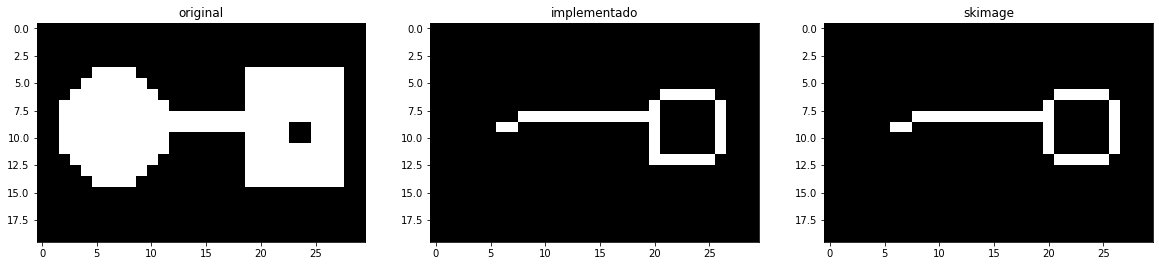

In [ ]:
# Lê a imagem.
img = plt.imread('images/shape.png')
img = (img > 0).astype(np.uint8)
image_info(img)

# Realiza o esqueleto com a implementação local e de uma biblioteca já pronta para comparação.
img_esqueleto = esqueleto(img)
img_esqueleto_skimage = skeletonize(img)

# Realiza o plot da imagem original, da implementada e da biblioteca.
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
axs[0].imshow(img, 'gray')
axs[0].set_title('original')
axs[1].imshow(img_esqueleto, 'gray')
axs[1].set_title('implementado')
axs[2].imshow(img_esqueleto_skimage, 'gray')
axs[2].set_title('skimage')

Tamanho: (64, 64)
Tipo de Dado: uint8
Menor Valor: 0
Maior Valor: 1
Valores Unicos: 2


Text(0.5, 1.0, 'skimage')

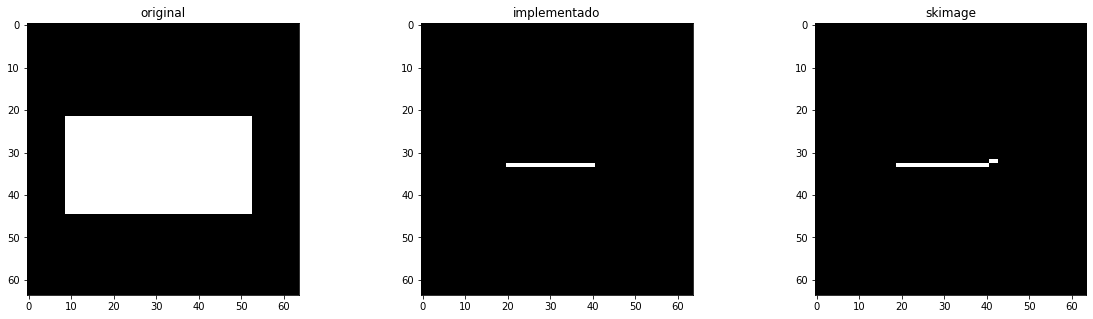

In [ ]:
# Lê a imagem.
img = plt.imread('images/retangulo.GIF')
img = img[:, :, 0]
img = (img > 0).astype(np.uint8)
image_info(img)

# Realiza o esqueleto com a implementação local e de uma biblioteca já pronta para comparação.
img_esqueleto = esqueleto(img)
img_esqueleto_skimage = skeletonize(img)

# Realiza o plot da imagem original, da implementada e da biblioteca.
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
axs[0].imshow(img, 'gray')
axs[0].set_title('original')
axs[1].imshow(img_esqueleto, 'gray')
axs[1].set_title('implementado')
axs[2].imshow(img_esqueleto_skimage, 'gray')
axs[2].set_title('skimage')

Tamanho: (96, 128)
Tipo de Dado: uint8
Menor Valor: 0
Maior Valor: 1
Valores Unicos: 2


Text(0.5, 1.0, 'skimage')

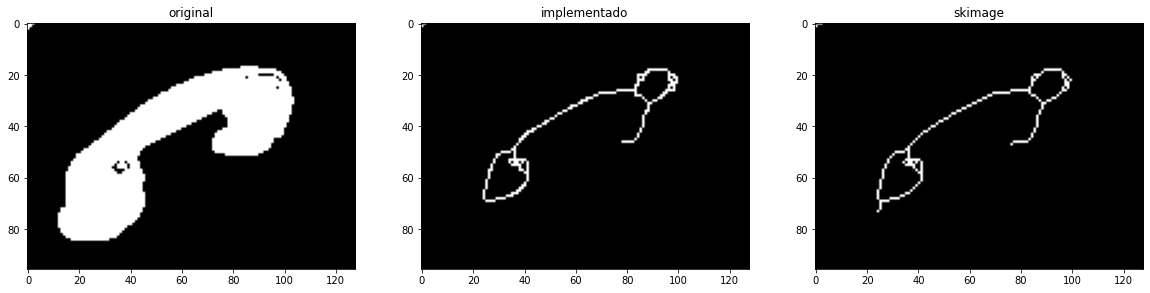

In [ ]:
# Lê a imagem.
img = plt.imread('images/telefone.GIF')
img = img[:, :, 0]
img = (img > 0).astype(np.uint8)
image_info(img)

# Realiza o esqueleto com a implementação local e de uma biblioteca já pronta para comparação.
img_esqueleto = esqueleto(img)
img_esqueleto_skimage = skeletonize(img)

# Realiza o plot da imagem original, da implementada e da biblioteca.
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
axs[0].imshow(img, 'gray')
axs[0].set_title('original')
axs[1].imshow(img_esqueleto, 'gray')
axs[1].set_title('implementado')
axs[2].imshow(img_esqueleto_skimage, 'gray')
axs[2].set_title('skimage')

Tamanho: (131, 160)
Tipo de Dado: uint8
Menor Valor: 0
Maior Valor: 1
Valores Unicos: 2


Text(0.5, 1.0, 'skimage')

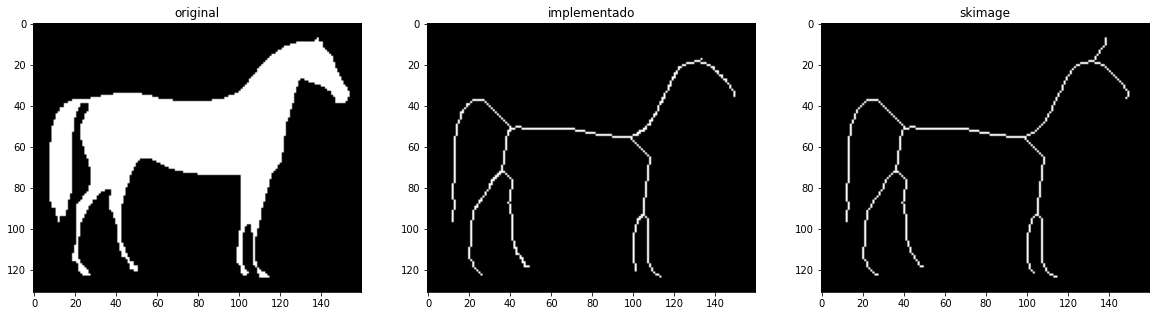

In [ ]:
from skimage.transform import rescale

# Lê a imagem.
img = data.horse()
img = ~img
img = (img == True).astype(np.uint8)
img = rescale(img, 0.4)
img = (img > 0).astype(np.uint8)
image_info(img)

# Realiza o esqueleto com a implementação local e de uma biblioteca já pronta para comparação.
img_esqueleto = esqueleto(img)
img_esqueleto_skimage = skeletonize(img)

# Realiza o plot da imagem original, da implementada e da biblioteca.
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
axs[0].imshow(img, 'gray')
axs[0].set_title('original')
axs[1].imshow(img_esqueleto, 'gray')
axs[1].set_title('implementado')
axs[2].imshow(img_esqueleto_skimage, 'gray')
axs[2].set_title('skimage')